<h1><center> BP reconstruction - Alexnet retrained with ConvPool instead of Pool </center></h1>
<h2><center> Retrain all AlexNet layers </center></h2>

### Main conclusion: Retraining all layers Unlearns the convolutional layers making that the reconstruction does not work even on Conv Layers

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#! pip install git+https://github.com/modestyachts/ImageNetV2_pytorch#

In [6]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F2
torch.cuda.empty_cache()
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

output_images_dir = 'output_images_convPool_retrainAll' # Images for the replacement of pool by strided conv

In [7]:
#! wget --no-check-certificate https://leslietj.github.io/image/guided_backpropagation_6.png

## Download MNIST 
and take 1 random image from each digit

In [8]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
from PIL import Image
import matplotlib.pyplot as plt
# Define the data transform to normalize the image data
transform = transforms.Compose([
    transforms.ToTensor(),  # convert PIL image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # normalize the image data
])
# # Download the MNIST dataset and apply the data transform
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dictionary to store one random image from each class
random_mnist_images = {}
# Loop through the dataset to find one random image from each class
for i in range(len(trainset)):
    image, label = trainset[i]
    if label not in random_mnist_images:
        random_mnist_images[label] = image
        if len(random_mnist_images) == 10:
            break

In [9]:
random_mnist_images.keys()

dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])

## `Modified AlexNet with striedConv instead of Pool`

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Load and modify the AlexNet model (as per the previous code)
alexnet = models.alexnet(pretrained=True)

def replace_pool_with_conv(model):
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.MaxPool2d):
            # Find the last conv layer before this pooling layer
            j = i - 1
            while not isinstance(model.features[j], nn.Conv2d):
                j -= 1

            # Get the number of output channels from the last conv layer
            out_channels = model.features[j].out_channels

            # Create a new conv layer to replace the pooling layer
            conv = nn.Conv2d(in_channels=out_channels,
                             out_channels=out_channels,
                             kernel_size=3, stride=2, padding=0)
            model.features[i] = conv
    return model

modified_alexnet = replace_pool_with_conv(alexnet)

/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/anaconda/anaconda3/envs/elias/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
for i, child in enumerate(modified_alexnet.features):
    print(i,child)

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
4 ReLU(inplace=True)
5 Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
6 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 ReLU(inplace=True)
8 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
9 ReLU(inplace=True)
10 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))


## `Re-train on ImageNetV2`

In [12]:
#! pip install git+https://github.com/modestyachts/ImageNetV2_pytorch
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from imagenetv2_pytorch import ImageNetV2Dataset
from torch.utils.data import DataLoader, Subset
import random
import os, warnings

from torch.optim.lr_scheduler import ReduceLROnPlateau
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)
def load_model(model_path, model_architecture):
    model_architecture.load_state_dict(torch.load(model_path,map_location = device))
    model_architecture.to(device)
    return model_architecture
#############################################
os.environ['CURL_CA_BUNDLE'] = ''
os.environ['REQUESTS_CA_BUNDLE'] = ''
warnings.filterwarnings("ignore")
PROXIES = {'https': 'http://localhost:3166', 'http': 'http://localhost:3166'}

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Load ImageNetV2 dataset
dataset = ImageNetV2Dataset("matched-frequency",transform=transform)  # choose the variant you need

from torch.utils.data import random_split
# Split dataset into training and validation subsets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation subsets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)
#<strainloader = torch.utils.data.DataLoader(dataset_subset, batch_size=8, shuffle=True, num_workers=4)

### `retrain all layer`

In [14]:
train=1 #Do not train the model, load it, change to one if you train

In [15]:
if train == 0:
    modified_alexnet = load_model('best_model_train_all_layers_3.pt', modified_alexnet)
else:
    # Define the optimizer and scheduler
    optimizer = optim.SGD(modified_alexnet.parameters(), lr=0.00001, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    criterion = nn.CrossEntropyLoss()
    modified_alexnet.to(device)
    ############# To check ####################
    # Initially, unfreeze only the newly added/modified convolutional layers (assuming these are layers 2, 4, 8 in 'features')
    layers_to_unfreeze_initially = [2, 5, 12] #correspond to ex Pooling layers 2,4, 8
    for i, child in enumerate(modified_alexnet.features):
        if i in layers_to_unfreeze_initially:
            for param in child.parameters():
                param.requires_grad = True

    # Gradual Unfreezing: Define the layers (indices in 'features') to unfreeze over epochs
    unfreeze_schedule = { #3,6,8,10
        4: [0, 3, 6],
        6: [8, 10],
        10: 'classifier'  # Unfreeze the fully connected layers
    }

    # Training loop
    num_epochs = 80
    patience = 10
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        if epoch in unfreeze_schedule:
            layers_to_unfreeze = unfreeze_schedule[epoch]
            if layers_to_unfreeze == 'classifier':
                # Unfreeze the fully connected layers
                for param in modified_alexnet.classifier.parameters():
                    param.requires_grad = True
            else:
                # Unfreeze specified layers in 'features'
                for i in layers_to_unfreeze:
                    for param in modified_alexnet.features[i].parameters():
                        param.requires_grad = True
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = modified_alexnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Evaluate the model on the validation set
        val_loss = evaluate(modified_alexnet, val_loader, criterion)

        # Update the learning rate scheduler
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset counter
            # Save the best model
            torch.save(modified_alexnet.state_dict(), 'best_model_train_all_layers_3.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:# Early stopping
                print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
                break
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1, Loss: 6.864135136604309
Epoch 1, Train Loss: 6.8641, Val Loss: 6.8073
Epoch 2, Loss: 6.71965858745575
Epoch 2, Train Loss: 6.7197, Val Loss: 6.6451
Epoch 3, Loss: 6.513638308525086
Epoch 3, Train Loss: 6.5136, Val Loss: 6.4536
Epoch 4, Loss: 6.335263450622558
Epoch 4, Train Loss: 6.3353, Val Loss: 6.3024
Epoch 5, Loss: 6.202598413944244
Epoch 5, Train Loss: 6.2026, Val Loss: 6.1731
Epoch 6, Loss: 6.088791476249694
Epoch 6, Train Loss: 6.0888, Val Loss: 6.1189
Epoch 7, Loss: 5.979950063228607
Epoch 7, Train Loss: 5.9800, Val Loss: 6.1184
Epoch 8, Loss: 5.878643196582794
Epoch 8, Train Loss: 5.8786, Val Loss: 5.9895
Epoch 9, Loss: 5.7968990187644955
Epoch 9, Train Loss: 5.7969, Val Loss: 5.9127
Epoch 10, Loss: 5.719788916110993
Epoch 10, Train Loss: 5.7198, Val Loss: 5.8942
Epoch 11, Loss: 5.636139743328094
Epoch 11, Train Loss: 5.6361, Val Loss: 5.8624
Epoch 12, Loss: 5.554052266836166
Epoch 12, Train Loss: 5.5541, Val Loss: 5.8353
Epoch 13, Loss: 5.4855249133110044
Epoch 13, T

In [34]:
# # Save the modified AlexNet model
# torch.save(modified_alexnet.state_dict(), 'modified_alexnet.pth')
# print('Model Saved Successfully')

In [16]:
import os
import ipywidgets as widgets
from IPython.display import display
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

epsilon=1e-8
large_n = 1e8

In [17]:
def reconstructed_input_dense_simple(weights, activations, take_positive = 0):
    """
    Use a mask instead in order to find this problem
    Args: 
        - weights: of shape (N_dim_output, Dim_prev_hidden)
        - activations: of shape (1,N_dim_output)
    Output:
        - reconstructed_input : top weights * corresponding activations
    """
    if take_positive:
        activations = torch.clamp(activations, min =0.0) 
    reconstructed_input = torch.matmul(activations,weights)
    return reconstructed_input

In [18]:
def reconstructed_input_conv2D_correct(activations, weights, stride=(1,1), padding=(0,0), does_winner_take_all= 0):
    """
    This function needs to be tested, to be sure it does what is expected
    Args: 
        - weights: of shape (C_out, C_in, kH, kW)
        - activations: of shape (B, C_out, H_out, W_out)
        - stride: default is (1,1)
        - padding: default is (0,0)
    Output:
        - reconstructed_input : An approximation of backpropagation from selected activations back to the input regions that lead to them
    """
    # get the batch size, number of output channels, out height, and out width
    B, C_out, H_out, W_out = activations.shape
    C_out, C_in_, kH, kW = weights.shape
    # calculate the input height and width
    H = (H_out - 1) * stride[0] + kH - 2 * padding[0]
    W = (W_out - 1) * stride[1] + kW - 2 * padding[1]
    # initialize the input tensor to reconstruct with zeros
    reconstructed_input = torch.zeros(B, C_in_, H, W).to(device)
    reconstructed_input = F.pad(reconstructed_input, (padding[1], padding[1], padding[0], padding[0]))
    if does_winner_take_all == 1:
        activations = winner_takes_all(activations)
    # loop through each example in the batch
    for b in range(B):
        # loop through each output channel
        for c_out in range(C_out):
            # loop through each output location
            for i in range(0, H_out):
                for j in range(0, W_out):
                    reconstructed_input[b, :, i*stride[0]:i*stride[0]+kH, j*stride[1]:j*stride[1]+kW] += torch.mul(weights[c_out, :, :, :], activations[b, c_out, i, j])
    if padding[0] == 0 and padding[1] == 0:
        return reconstructed_input
    else:
        return reconstructed_input[:, :, padding[0]:-padding[0], padding[1]:-padding[1]]

def winner_takes_all(activations):
    # Get the maximum activation value and its index along the channel axis (C_out)
    max_value, max_index = torch.max(activations, dim=1)
    # Create a tensor of the same shape as the activations, but with all elements set to zero
    zero_tensor = torch.zeros_like(activations)
    # Use the max_index to set the corresponding activation to the max_value, and zero out the other activations
    for b in range(activations.shape[0]):
        for h in range(activations.shape[2]):
            for w in range(activations.shape[3]):
                zero_tensor[b, max_index[b, h, w], h, w] = max_value[b, h, w]
    return zero_tensor

In [19]:
# A bit of a mess, clean later
def de_normalize(tensor, mean, std):
    for i, (m, s) in enumerate(zip(mean, std)):
        tensor[i] = tensor[i] * s + m
    return tensor
# def de_normalize(tensor, mean, std):
#     for i, (m, s) in enumerate(zip(mean, std)):
#         tensor[i] = tensor[i] * torch.tensor(s, device=tensor.device) + torch.tensor(m, device=tensor.device)
#     return tensor


def reverse_transform(img_tensor):
    # Step 1: De-normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    de_normalized_tensor = de_normalize(img_tensor.clone().squeeze(), mean, std)
    img = F2.to_pil_image(de_normalized_tensor)
    #Cropping is irreversible
    return img

def normalize_image_norescale(image):
    """
    Normalize only
    """
    norm = (image - image.mean())/image.std()
    return norm

def normalize_image(image):
    """
    Normalize and Rescale
    """
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm


def normalize_image_minmax_norescale(image):
    """
    Normalize using min/max and Rescale
    """
    image = (image - image.min()) / (image.max() - image.min())
    return image

def normalize(X, normalization_method="normalize_std", new_min=-1, new_max=1):
    if X.dim() == 4:  # Conv layer (batch, channel, h, w)
        axis = (2, 3)
    elif X.dim() == 2:  # Dense layer (batch, N)
        axis = 1
    else:
        raise ValueError("Input tensor must have 2 or 4 dimensions")
    if normalization_method == "normalize_std": #Local normalization only
        X -= X.mean(axis, keepdim=True)
        X /= X.std(axis, keepdim=True)
    elif  normalization_method == "normalize_std_global":
        X = (X - X.mean()) / X.std()
    elif normalization_method == "normalize_rescale_std":
        X = (X - X.mean()) / X.std()
        X = X * 0.1 + 0.5
        X = X.clip(0, 1)
    elif normalization_method == "normalize_rescale_std_local":
        X -= X.mean(axis, keepdim=True)
        X /= X.std(axis, keepdim=True)
        X = X * 0.1 + 0.5
        X = X.clip(0, 1)
    elif normalization_method == "normalize_minmax_rescale":
        X = (X - X.min()) / (X.max() - X.min())
        X = X * (new_max - new_min) + new_min
        X = X.clip(new_min, new_max)
    elif normalization_method == "normalize_minmax":
        X = (X - X.min()) / (X.max() - X.min())
    elif normalization_method == "normalize_minmax_local":
        if axis == 1:
            X_min =  X.min(dim = axis, keepdim=True).values
            X_max =  X.max(dim = axis, keepdim=True).values
        else:
            X_min=X
            X_max=X
            for dim in axis:
                X_min =  X_min.min(dim = dim, keepdim=True).values
                X_max =  X_max.max(dim = dim, keepdim=True).values                
        X = (X -X_min) / ( X_max - X_min)
    elif normalization_method == "normalize_minmax_01_05_rescale":
        X = (X - X.min()) / (X.max() - X.min())
        X = X * 0.1 + 0.5
        X = X.clip(0, 1)
    else:
        raise ValueError("Invalid normalization method")
    X = fix_nan(X)
    return X

def activation(X, normalization_method="thresh_00"):
    if normalization_method == "thresh_00": #Local normalization only
        X[X < 0] = 0
    elif normalization_method == "thresh_01":
        X[X < 0.1] = 0
    elif normalization_method == "thresh_02":
        X[X < 0.2] = 0
    elif normalization_method == "thresh_03":
        X[X < 0.3] = 0
    else:
        raise ValueError("Invalid normalization method")
    X = fix_nan(X)
    return X

def fix_nan(reconstructed_input):
    nan_inf_exist = torch.isnan(reconstructed_input).any() or torch.isinf(reconstructed_input).any()
    # Replace NaN values with a small positive number epsilon
    reconstructed_input = torch.where(torch.isnan(reconstructed_input), torch.tensor(epsilon).to(device), reconstructed_input)
    # Replace positive infinity with a large positive number
    pos_inf_mask = torch.isinf(reconstructed_input) & (reconstructed_input > 0)
    reconstructed_input = torch.where(pos_inf_mask, torch.tensor(large_n).to(device), reconstructed_input)
    # Replace negative infinity with a large negative number
    neg_inf_mask = torch.isinf(reconstructed_input) & (reconstructed_input < 0)
    reconstructed_input = torch.where(neg_inf_mask, torch.tensor(large_n).to(device), reconstructed_input)
    nan_inf_exist = torch.isnan(reconstructed_input).any() or torch.isinf(reconstructed_input).any()
    return reconstructed_input

## `Dashboard`

In [20]:
from ipywidgets import FileUpload
import torch
from io import BytesIO

import torch

def reconstruct_image(im_class, reconstruction_method, Positivise, Positivise_conv, Normalize, does_winner_take_all, take_positive, normalization_method, tensor_viz = 'normalize'):
    # Load pretrained AlexNet model
    model = modified_alexnet #models.alexnet(pretrained=True)
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Check if an image is uploaded
    if im_class == 'Upload your own file':
        if upload_widget.value:
            uploaded_image = list(upload_widget.value.values())[0]
            image_content = uploaded_image['content']
            image = Image.open(BytesIO(image_content)).convert('RGB')
            #upload_widget.value.clear() # clear the uploaded image after processing
        else:
            display('No File has been uploaded', upload_widget.value)
            return
    #elif 'rot' in im_class:
    #    image = Image.open(f'./{im_class}.png').convert('RGB')
    elif im_class not in set([str(i) for i in random_mnist_images.keys()]):
        image = Image.open(f'./{im_class}').convert('RGB')
    else:
        image = random_mnist_images[int(im_class)]
        image = (image * 0.5) + 0.5
        # Convert the PyTorch tensor to a PIL Image for display
        image = transforms.ToPILImage()(image)
        # Convert the PIL Image to RGB format
        image = image.convert('RGB')
    img_tensor = transform(image).unsqueeze(0).requires_grad_()
    img_tensor = img_tensor.to(device)
    # Extract all weights and biases
    weights = [p.data for p in model.parameters()]
    # Define activation functions
    relu = torch.nn.ReLU(inplace=True)
    # Define layer-by-layer operations
    x = img_tensor.detach()
    # Convolution 1
    w1, b1 = weights[0], weights[1]
    #(0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    x = torch.nn.functional.conv2d(x, w1, b1, stride=4, padding=2)
    c1 = x.detach()
    x = relu(x)
    c1rel = x.detach()
    # Old MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    # Replaced by strided conv that was slightly retrained on Cifar 
    w1p, b1p = weights[2], weights[3]
    x = torch.nn.functional.conv2d(x, w1p, b1p, stride=2, padding=0)
    c1relmp = x.detach()

    # Convolution 2
    w2, b2 = weights[4], weights[5]
    #(3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    x = torch.nn.functional.conv2d(x, w2, b2, stride=1, padding=2)
    c2=x.detach()
    x = relu(x)
    c2rel=x.detach()
    #Old (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    #replaced by conv:
    w2p, b2p = weights[6], weights[7]
    x = torch.nn.functional.conv2d(x, w2p, b2p, stride=2, padding=0)
    c2relmp = x.detach()

    # Convolution 3
    w3, b3 = weights[8], weights[9]
    #(6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  
    x = torch.nn.functional.conv2d(x, w3, b3, stride=1, padding=1)
    x = relu(x)
    c3rel = x.detach()

    # Convolution 4
    w4, b4 = weights[10], weights[11]
    #(8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    x = torch.nn.functional.conv2d(x, w4, b4, stride=1, padding=1)
    x = relu(x)
    c4rel = x.detach()

    # Convolution 5
    w5, b5 = weights[12], weights[13]
    #(10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    x = torch.nn.functional.conv2d(x, w5, b5, stride=1, padding=1)
    c5 = x.detach()
    x = relu(x)
    c5rel = x.detach()
    #(12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    #replaced by new Conv
    w5p, b5p = weights[14], weights[15]
    x = torch.nn.functional.conv2d(x, w5p, b5p, stride=2, padding=0)
    c5relmp = x.detach()
    x = torch.nn.functional.adaptive_avg_pool2d(x,output_size=(6, 6))

    # Fully connected 1
    x = x.view(x.shape[0], -1)
    w6, b6 = weights[16], weights[17]
    x = torch.nn.functional.linear(x, w6, b6)
    x = relu(x)
    fc1rel = x.detach()

    # Fully connected 2
    w7, b7 = weights[18], weights[19]
    x = torch.nn.functional.linear(x, w7, b7)
    fc2 = x.detach()
    x = relu(x)
    fc2rel = x.detach()

    # Fully connected 3
    w8, b8 = weights[20], weights[21]
    x = torch.nn.functional.linear(x, w8, b8)
    x = relu(x)
    fc3rel = x.detach()
    model.eval()
    with torch.no_grad():
        # Forward pass
        output = model(img_tensor)
        pred_class = output.argmax().item() 
        print(pred_class)
    #assert torch.equal(x,output)
    if reconstruction_method == "general_class":
        target_class = pred_class # e.g. let's do the backpropagation of the resulting class in general 
        source_pointer_neurons = torch.zeros(output.shape, dtype=torch.float)
        source_pointer_neurons[0][target_class] = 1
        source_pointer_neurons = source_pointer_neurons.to(device)
        # Fully connected 3 
        reconstructed_input = reconstructed_input_dense_simple(w8, source_pointer_neurons, take_positive)
        reconstructed_input = reconstructed_input.to(device)
        if Normalize:
            reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
        if Positivise:
            reconstructed_input[reconstructed_input < 0] = 0
    elif reconstruction_method == "random_neuron":
        while True:
            target_class = random.randint(1,999) # 1000 classes 
            if target_class != pred_class:
                break
        print('reconstructing class:',target_class)
        source_pointer_neurons = torch.zeros(output.shape, dtype=torch.float)
        source_pointer_neurons[0][target_class] = 1
        source_pointer_neurons = source_pointer_neurons.to(device)
        # Fully connected 3 
        reconstructed_input = reconstructed_input_dense_simple(w8, source_pointer_neurons, take_positive)
        min_v = torch.min(reconstructed_input)
        max_v = torch.max(reconstructed_input)
        reconstructed_input = (max_v - min_v) * torch.rand(1,4096) + min_v
        reconstructed_input = fix_nan(reconstructed_input)
        if Normalize:
            reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
        if Positivise:
            reconstructed_input[reconstructed_input < 0] = 0
    elif reconstruction_method == "last_layer":
        reconstructed_input = fc3rel.detach()
        reconstructed_input = reconstructed_input.to(device)
        if Normalize:
            reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
        if Positivise: # redundant with the top selection
            reconstructed_input[reconstructed_input < 0] = 0
        # Fully connected 3
        reconstructed_input = reconstructed_input_dense_simple(w8, reconstructed_input, take_positive)
        if Normalize:
            reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
        if Positivise: # redundant with the top selection
            reconstructed_input[reconstructed_input < 0] = 0
    else:# the rest of the reconstruction methods (source1 till sourceX) Dirty implementation, but i'm in a hurry, hein! trying to finish before GPT5 :p
        reconstructed_input = torch.randn_like(fc2rel)
    if reconstruction_method == "source1":
        reconstructed_input = fc2rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise: # redundant with the top selection
        reconstructed_input[reconstructed_input < 0] = 0
    # Reverse Fully connected 2
    reconstructed_input = reconstructed_input_dense_simple(w7, reconstructed_input, take_positive)
    if reconstruction_method == "source2":
        reconstructed_input = fc1rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise: # redundant with the top selection
        reconstructed_input[reconstructed_input < 0] = 0
    # Fully connected 1
    reconstructed_input = reconstructed_input_dense_simple(w6, reconstructed_input, take_positive)
    if reconstruction_method == "source3":
        reconstructed_input = c5relmp.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise:
        reconstructed_input[reconstructed_input < 0] = 0
    #Adaptive avg pooing reversed:
    reconstructed_input = reconstructed_input
    ## Backward for conv replacement of pool
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input.reshape(1,256,6,6), w5p, stride=(2,2), padding=(0,0), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source4":
        reconstructed_input = c5rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    ## Backward for conv layers
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w5, stride=(1,1), padding=(1,1), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source5":
        reconstructed_input = c4rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w4, stride=(1,1), padding=(1,1), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source6":
        reconstructed_input = c3rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w3, stride=(1,1), padding=(1,1), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source7":
        reconstructed_input = c2relmp.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    ## Backward for conv replacement of pool
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w2p, stride=(2,2), padding=(0,0), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source8":
        reconstructed_input = c2rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w2, stride=(1,1), padding=(2,2), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source9":
        reconstructed_input = c1relmp.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    ## Backward for conv replacement of pool
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w1p, stride=(2,2), padding=(0,0), does_winner_take_all = does_winner_take_all)
    if reconstruction_method == "source10":
        reconstructed_input = c1rel.detach()
        reconstructed_input = reconstructed_input.to(device)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0
    reconstructed_input = reconstructed_input_conv2D_correct(reconstructed_input, w1, stride=(4,4), padding=(2,2), does_winner_take_all = does_winner_take_all)
    if Normalize:
        reconstructed_input = normalize(reconstructed_input, normalization_method=normalization_method)
    if Positivise_conv:
        reconstructed_input[reconstructed_input < 0] = 0 
    #back to CPU to finish 
    reconstructed_input = reconstructed_input.cpu()
    reconstructed_image = reconstructed_input[0].permute(1,2,0)
    if tensor_viz == 'normalize':
        reconstructed_image = normalize_image(reconstructed_image)
    elif tensor_viz == 'normalize_std_norescale':
        reconstructed_image = normalize_image_norescale(reconstructed_image)
    elif tensor_viz == 'reverse_transform':
        reconstructed_image = reverse_transform(reconstructed_input[0].detach())#may be reconstructed_image.detach().numpy()
    elif tensor_viz =='normalize_image_minmax_norescale':
        reconstructed_image = normalize_image_minmax_norescale(reconstructed_image)
    # Save and display the images
    output_dir = f'{output_images_dir}/{im_class[:-4]}/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    original_image_path = os.path.join(output_dir, f'{im_class}_original.png')
    reconstructed_image_path = os.path.join(output_dir, f"{im_class}_{reconstruction_method}_{'Pos' if Positivise else 'Neg'}_{'PosConv' if Positivise_conv else 'NegConv'}_{'Norm' if Normalize else 'Unnorm'}_{does_winner_take_all}_{'TakePos' if take_positive else 'NoTakePos'}_{normalization_method}_{tensor_viz}.png")
    if tensor_viz == 'normalize' or tensor_viz == 'normalize_image_minmax_norescale' or tensor_viz == 'normalize_std_norescale':
        reconstructed_image_pil = Image.fromarray((reconstructed_image.cpu().numpy() * 255).astype(np.uint8))
        reconstructed_image_pil.save(reconstructed_image_path)
    else:
        reconstructed_image.save(reconstructed_image_path)
    resized_original_image = reverse_transform(img_tensor)
    resized_original_image.save(original_image_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(resized_original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(reconstructed_image)
    ax[1].set_title('Reconstructed Image')
    plt.show()
    return reconstructed_input

# Create widgets
im_class_widget = widgets.Dropdown(options=['rot.png','Upload your own file', 'cat.jpg','Cat_word.png','cat_reconstruct.jpg','Berkeley.jpg','Leibniz.jpg','zied.jpg','5', '0', '4', '1', '9', '2', '3', '6', '7', '8'], description='Image:')
reconstruction_method_widget = widgets.Dropdown(options=['last_layer','general_class','random_neuron','source1','source2','source3','source4','source5','source6','source7','source8','source9','source10'], description='Reconstruction:')
Positivise_widget = widgets.Checkbox(value=True, description='Positivise')
Positivise_conv_widget = widgets.Checkbox(value=True, description='Positivise_conv')
Normalize_widget = widgets.Checkbox(value=True, description='Normalize')
does_winner_take_all_widget = widgets.Dropdown(options=[0, 1], description='Winner Takes All:')
take_positive_widget = widgets.Checkbox(value=False, description='Take Positive')#Should be deprecated, don't have time :/
normalization_method_widget = widgets.Dropdown(options=['normalize_rescale_std','normalize_std', 'normalize_minmax_rescale','normalize_std_global', 'normalize_rescale_std_local','normalize_minmax_01_05_rescale','normalize_minmax_local', 'normalize_minmax'], description='Normalization Method:')
#activation_method_widget = widgets.Dropdown(options=['thresh_00','thresh_01','thresh_02','thresh_03'], description='Activation Method:')# 
tensor_visualization_widget = widgets.Dropdown(options=['reverse_transform','normalize','normalize_image_minmax_norescale','normalize_std_norescale'], description='Tensor visualization Method:')
upload_widget = FileUpload(description='Upload Photo', accept='image/*', multiple=False)
upload_widget.layout.visibility = 'hidden' # set initial visibility to 'hidden'

#normalize_std_global', 'normalize_rescale_std_local','normalize_minmax_01_05', 'normalize_minmax', 'normalize_minmax_local'

# Create button
run_button = widgets.Button(description='Reconstruct Image')
output = widgets.Output()

def on_im_class_change(change):
    if change['new'] == 'Upload your own file':
        upload_widget.layout.visibility = 'visible'
    else:
        upload_widget.layout.visibility = 'hidden'

im_class_widget.observe(on_im_class_change, names='value')

def on_upload_button_click(change):
    if change['type'] == 'change' and change['name'] == 'value' and change['new'] is not None:
        im_class_widget.value = 'Upload your own file'
        #upload_widget.value.clear()

upload_widget.observe(on_upload_button_click)

def on_button_click(button):
    with output:
        output.clear_output()
        output_dir = f'{output_images_dir}/{im_class_widget.value[:-4]}/'
        # Generate the filename based on the current widget values
        filename = f"{im_class_widget.value}_{reconstruction_method_widget.value}_{'Pos' if Positivise_widget.value else 'Neg'}_{'PosConv' if Positivise_conv_widget.value else 'NegConv'}_{'Norm' if Normalize_widget.value else 'Unnorm'}_{does_winner_take_all_widget.value}_{'TakePos' if take_positive_widget.value else 'NoTakePos'}_{normalization_method_widget.value}_{tensor_visualization_widget.value}.png"
        reconstructed_image_path = os.path.join(output_dir, filename)
        # Check if the image with this filename already exists:
        if os.path.exists(reconstructed_image_path):
            resized_original_image = Image.open(os.path.join(output_dir, f'{im_class_widget.value}_original.png'))
            reconstructed_image = Image.open(reconstructed_image_path)
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(resized_original_image)
            ax[0].set_title('Original Image')
            ax[1].imshow(reconstructed_image)
            ax[1].set_title('Reconstructed Image')
            plt.show()
        else:
            reconstruct_image(
                im_class_widget.value,
                reconstruction_method_widget.value,
                Positivise_widget.value,
                Positivise_conv_widget.value,
                Normalize_widget.value,
                does_winner_take_all_widget.value,
                take_positive_widget.value,
                normalization_method_widget.value,
                tensor_visualization_widget.value
                #activation_method_widget.value
                )
            
run_button.on_click(on_button_click)

# Display widgets
display(im_class_widget)
display(reconstruction_method_widget)
display(Positivise_widget)
display(Positivise_conv_widget)
display(Normalize_widget)
display(does_winner_take_all_widget)
display(take_positive_widget)
display(normalization_method_widget)
display(tensor_visualization_widget)
display(upload_widget)
display(output)
display(run_button)

Dropdown(description='Image:', options=('rot.png', 'Upload your own file', 'cat.jpg', 'Cat_word.png', 'cat_rec…

Dropdown(description='Reconstruction:', options=('last_layer', 'general_class', 'random_neuron', 'source1', 's…

Checkbox(value=True, description='Positivise')

Checkbox(value=True, description='Positivise_conv')

Checkbox(value=True, description='Normalize')

Dropdown(description='Winner Takes All:', options=(0, 1), value=0)

Checkbox(value=False, description='Take Positive')

Dropdown(description='Normalization Method:', options=('normalize_rescale_std', 'normalize_std', 'normalize_mi…

Dropdown(description='Tensor visualization Method:', options=('reverse_transform', 'normalize', 'normalize_ima…

FileUpload(value={}, accept='image/*', description='Upload Photo', layout=Layout(visibility='hidden'))

Output()

Button(description='Reconstruct Image', style=ButtonStyle())

In [21]:
image_classes = ['kitten.jpg', 'Cat_word.png', 'cat_reconstruct.jpg', 'Berkeley.jpg', 'Leibniz.jpg']
reconstruction_methods = ['last_layer', 'general_class']
positivise_options = [True, False]
positivise_conv_options = [True, False]
normalize_options = [True, False]
winner_take_all_options = [0, 1]
unpool_option = ['unpool_indices']  # later add 'upsample','unpool_random'
take_positive_options = [False] #redundant feature, should be deprecated
normalization_methods = ['normalize_rescale_std','normalize_std', 'normalize_minmax_rescale','normalize_std_global', 'normalize_rescale_std_local','normalize_minmax_01_05_rescale', 'normalize_minmax', 'normalize_minmax_local']
tensor_visualization_methods = ['reverse_transform', 'normalize','normalize_image_minmax_norescale','normalize_std_norescale']
import tqdm

def exhaustive_reconstruct():
    for im_class in tqdm.tqdm(image_classes):
        for reconstruction_method in tqdm.tqdm(reconstruction_methods):
            for Positivise in tqdm.tqdm(positivise_options):
                for Positivise_conv in tqdm.tqdm(positivise_conv_options):
                    for Normalize in tqdm.tqdm(normalize_options):
                        if Normalize==True:
                            for does_winner_take_all in tqdm.tqdm(winner_take_all_options):
                                for take_positive in tqdm.tqdm(take_positive_options):
                                    for normalization_method in tqdm.tqdm(normalization_methods):
                                        for tensor_viz in tqdm.tqdm(tensor_visualization_methods):
                                            for unpool_ in unpool_option:
                                                # Check if the image with this filename already exists:
                                                output_dir = f'{output_images_dir}/{im_class[:-4]}/'
                                                filename = f"{im_class}_{reconstruction_method}_{'Pos' if Positivise else 'Neg'}_{'PosConv' if Positivise_conv else 'NegConv'}_{'Norm' if Normalize else 'Unnorm'}_{does_winner_take_all}_{'TakePos' if take_positive else 'NoTakePos'}_{normalization_method}_{tensor_viz}.png"
                                                reconstructed_image_path = os.path.join(output_dir, filename)
                                                if os.path.exists(reconstructed_image_path):
                                                    print('exists, continue')
                                                    continue
                                                # If not, call my image reconstruction function
                                                reconstruct_image(
                                                    im_class,
                                                    reconstruction_method,
                                                    Positivise,
                                                    Positivise_conv,
                                                    Normalize,
                                                    does_winner_take_all,
                                                    take_positive,
                                                    normalization_method,
                                                    unpool_,
                                                    tensor_viz
                                                )
                        else:
                            for does_winner_take_all in tqdm.tqdm(winner_take_all_options):
                                for take_positive in tqdm.tqdm(take_positive_options):
                                    for tensor_viz in tqdm.tqdm(tensor_visualization_methods):
                                        for unpool_ in unpool_option:
                                            # Check if the image with this filename already exists:
                                            output_dir = f'{output_images_dir}/{im_class[:-4]}/'
                                            filename = f"{im_class}_{reconstruction_method}_{'Pos' if Positivise else 'Neg'}_{'PosConv' if Positivise_conv else 'NegConv'}_{'Norm' if Normalize else 'Unnorm'}_{does_winner_take_all}_{'TakePos' if take_positive else 'NoTakePos'}_{normalization_method}_{unpool_}_{tensor_viz}.png"
                                            reconstructed_image_path = os.path.join(output_dir, filename)
                                            if os.path.exists(reconstructed_image_path):
                                                print('exists, continue')
                                                continue
                                            # If not, call my image reconstruction function
                                            reconstruct_image(
                                                im_class,
                                                reconstruction_method,
                                                Positivise,
                                                Positivise_conv,
                                                Normalize,
                                                does_winner_take_all,
                                                take_positive,
                                                normalization_method,
                                                unpool_,
                                                tensor_viz
                                            )


# Run all experiments
exhaustive_reconstruct()

  0%|                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]



  0%|                                                                                                                                                                                                                  | 0/2 [00:00<?, ?it/s]




  0%|                                 

TypeError: reconstruct_image() takes from 8 to 9 positional arguments but 10 were given

  0%|                                                                                                                                  | 0/3 [00:00<?, ?it/s]

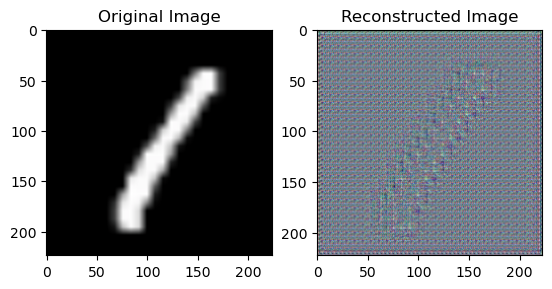


 33%|████████████████████████████████████████▋                                                                                 | 1/3 [00:27<00:55, 27.62s/it]

111


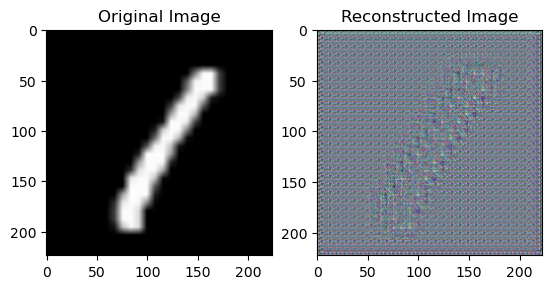


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 2/3 [00:55<00:27, 27.69s/it]

321


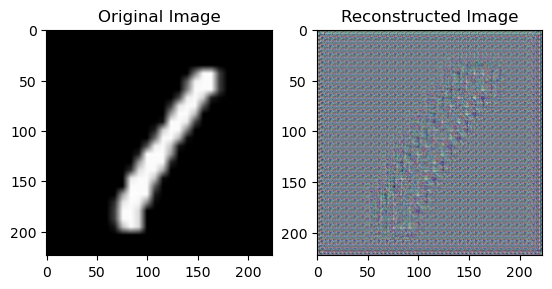


  0%|                                                                                                                                  | 0/3 [00:00<?, ?it/s]

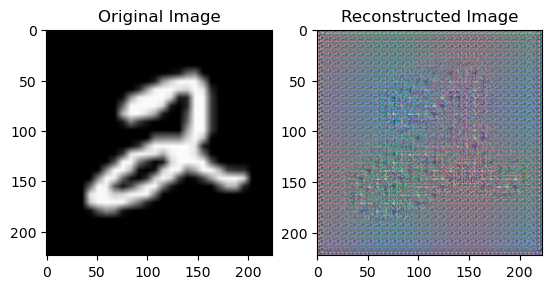


 33%|████████████████████████████████████████▋                                                                                 | 1/3 [00:27<00:55, 27.56s/it]

714


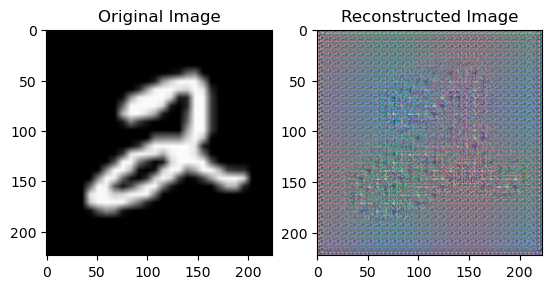


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 2/3 [00:55<00:27, 27.58s/it]

992


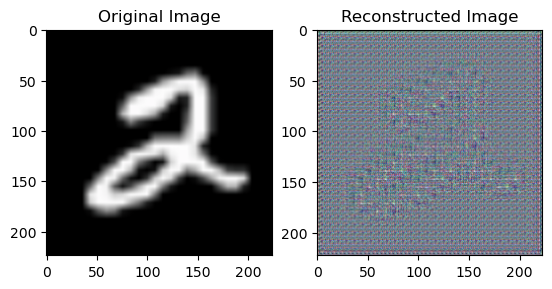


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:45<00:00, 82.86s/it]


In [21]:
# The parameters you want to exhaustively explore:
image_classes = ['1', '2']
reconstruction_methods = ['last_layer', 'general_class', 'random_neuron']
Positivise = True
Positivise_conv = True
Normalize = True
does_winner_take_all = 0
unpool_ = 'unpool_indices'  # Fixed, as you specified
take_positive = False #redundant feature, should be deprecated [True, False]
normalization_method = 'normalize_rescale_std' #['normalize_rescale_std', 'normalize_std', 'normalize_minmax_rescale']
tensor_viz = 'normalize'#['reverse_transform', 'normalize']
import tqdm

list_reconstructed = []

for im_class in tqdm.tqdm(image_classes):
    for reconstruction_method in tqdm.tqdm(reconstruction_methods):
        list_reconstructed.append(reconstruct_image(
            im_class,
            reconstruction_method,
            Positivise,
            Positivise_conv,
            Normalize,
            does_winner_take_all,
            take_positive,
            normalization_method,
            unpool_,
            tensor_viz
        ))

### `Comparing the difference between Single Neuron and Full Last layer`
#### The resulting construction  of `1` with a `single neuron`, against the same with `last layer`. Althought very close, visually, there is a slight difference between both

In [23]:
#https://pytorch.org/docs/stable/generated/torch.allclose.html
print(torch.allclose(list_reconstructed[0],list_reconstructed[1],rtol=1e-05, atol=1e-02),torch.allclose(list_reconstructed[0],list_reconstructed[1],rtol=1e-05, atol=1e-03))
print(torch.allclose(list_reconstructed[0],list_reconstructed[2],rtol=1e-05, atol=1e-02),torch.allclose(list_reconstructed[0],list_reconstructed[2],rtol=1e-05, atol=1e-03))
print(torch.allclose(list_reconstructed[1],list_reconstructed[2],rtol=1e-05, atol=1e-02),torch.allclose(list_reconstructed[1],list_reconstructed[2],rtol=1e-05, atol=1e-03))

True True
True True
True True


#### Let's look at the difference in more details

In [28]:
import torch

difference0_1 = torch.abs(list_reconstructed[0] - list_reconstructed[1])
max_difference = torch.max(difference)

print("The maximum difference between the two matrices is:", max_difference.item())

The maximum difference between the two matrices is: 0.0007911026477813721


In [29]:
import torch

difference1_2 = torch.abs(list_reconstructed[1] - list_reconstructed[2])
max_difference = torch.max(difference)

print("The maximum difference between the two matrices is:", max_difference.item())

The maximum difference between the two matrices is: 0.0007911026477813721


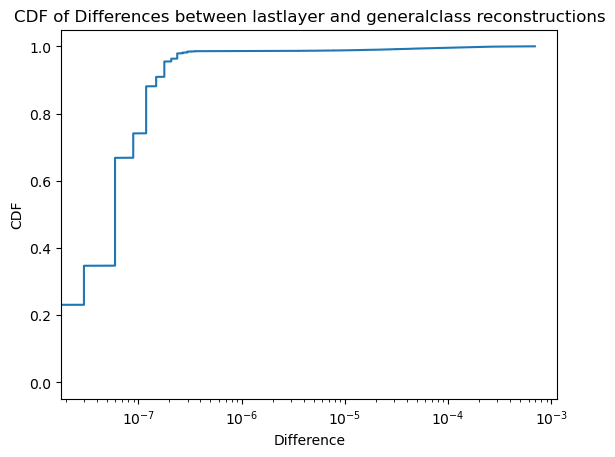

In [30]:
difference_flattened = difference0_1.flatten()
sorted_diffs = np.sort(difference_flattened.numpy())
yvals = np.arange(len(sorted_diffs))/float(len(sorted_diffs)-1)
plt.plot(sorted_diffs, yvals)
plt.xlabel('Difference')
plt.ylabel('CDF')
plt.xscale('log')
plt.title('CDF of Differences between lastlayer and generalclass reconstructions')
plt.show()

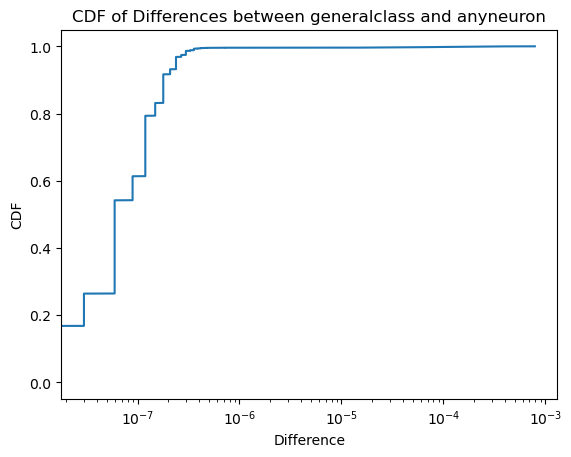

In [31]:
difference_flattened = difference1_2.flatten()
sorted_diffs = np.sort(difference_flattened.numpy())
yvals = np.arange(len(sorted_diffs))/float(len(sorted_diffs)-1)
plt.plot(sorted_diffs, yvals)
plt.xlabel('Difference')
plt.ylabel('CDF')
plt.xscale('log')
plt.title('CDF of Differences between generalclass and anyneuron')
plt.show()

#### As expected `1` and `2` are completely different

In [67]:
torch.allclose(list_reconstructed[1],list_reconstructed[2],rtol=1e-01, atol=1e-01)

(False, False)